# Time Series of Ireland Weather Data

## Note:
My student ID number ends in 6.
"cbl - Atmospheric Pressure (hectopascals)" is the variable on which forecasting will be done

# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from scipy import stats
from scipy.stats import shapiro, bartlett

## Read the Data

In [3]:
#read data
data= pd.read_csv('weather_revised.csv')

In [4]:
data.head()

,date,maxtp(Maximum Air Temperature - degrees C),mintp(Minimum Air Temperature - degrees C),gmin(Grass Minimum Temperature - degrees C),rain(Precipitation Amount - mm),cbl (Mean CBL Pressure-hpa),wdsp(Mean Wind Speed - knot),pe(Potential Evapotranspiration - mm),evap(Evaporation -mm)
0,1-Jan-42,9.7,6.8,4.7,0.0,1020.3,17.2,1.1,1.4
1,2-Jan-42,9.9,7.9,6.7,0.1,1016.2,15.2,0.7,0.9
2,3-Jan-42,11.2,8.9,7.2,1.5,1006.8,14.0,0.5,0.6
3,4-Jan-42,9.2,2.7,3.4,3.5,1001.5,17.0,0.6,0.7
4,5-Jan-42,3.5,-0.8,0,0.6,1013.4,13.0,0.6,0.7


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29889 entries, 0 to 29888
Data columns (total 9 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   date                                         29889 non-null  object 
 1   maxtp(Maximum Air Temperature - degrees C)   29889 non-null  float64
 2   mintp(Minimum Air Temperature - degrees C)   29889 non-null  float64
 3   gmin(Grass Minimum Temperature - degrees C)  29889 non-null  object 
 4   rain(Precipitation Amount - mm)              29889 non-null  float64
 5   cbl (Mean CBL Pressure-hpa)                  29889 non-null  float64
 6   wdsp(Mean Wind Speed - knot)                 29889 non-null  float64
 7   pe(Potential Evapotranspiration - mm)        29889 non-null  float64
 8   evap(Evaporation -mm)                        29889 non-null  object 
dtypes: float64(6), object(3)
memory usage: 2.1+ MB


<a id = 'eda'></a>

# Exploratory Data Analysis

In [6]:
#checking number of rows and columns
print('The number of rows:', data.shape[0])
print('The number of columns:', data.shape[1])

The number of rows: 29889
The number of columns: 9


In [7]:
# Selecting only 'date' and 'cbl' columns to make further analysis
data_cbl = data[['date', 'cbl (Mean CBL Pressure-hpa)']]
data_cbl

,date,cbl (Mean CBL Pressure-hpa)
0,1-Jan-42,1020.3
1,2-Jan-42,1016.2
2,3-Jan-42,1006.8
3,4-Jan-42,1001.5
4,5-Jan-42,1013.4
...,...,...
29884,27-Oct-23,974.2
29885,28-Oct-23,970.1
29886,29-Oct-23,972.0
29887,30-Oct-23,979.9


In [8]:
data_cbl.describe()

,cbl (Mean CBL Pressure-hpa)
count,29889.000000
mean,1003.520208
std,11.723154
min,949.600000
25%,996.200000
50%,1004.600000
75%,1011.700000
max,1037.400000


In [9]:
# Renaming Columns for better understandability 
data_cbl.rename(columns={'DATE':'date', 'cbl (Mean CBL Pressure-hpa)':'cbl_pressure'}, inplace=True)

In [10]:
data_cbl

,date,cbl_pressure
0,1-Jan-42,1020.3
1,2-Jan-42,1016.2
2,3-Jan-42,1006.8
3,4-Jan-42,1001.5
4,5-Jan-42,1013.4
...,...,...
29884,27-Oct-23,974.2
29885,28-Oct-23,970.1
29886,29-Oct-23,972.0
29887,30-Oct-23,979.9


In [11]:
#checking missing values
data_cbl.isna().sum()

date            0
cbl_pressure    0
dtype: int64

There are no missing values in data as seen above

In [12]:
data_cbl.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29889 entries, 0 to 29888
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          29889 non-null  object 
 1   cbl_pressure  29889 non-null  float64
dtypes: float64(1), object(1)
memory usage: 467.1+ KB


- "date" is in object datatype. We'll convert it into datetime datatype.
- "cbl (Mean CBL Pressure-hpa)" is in float datatype.

In [13]:
#date is inot in the required format for analysis hence modifying it 
# split the date by '-'
data_cbl[['day', 'month', 'year']] = data_cbl['date'].str.split('-', expand=True)

# year, add 1900 and 2000 make it year
data_cbl['year'] = data_cbl['year'].astype(int)
data_cbl['year'] = data_cbl['year'].apply(lambda x: 1900 + x if 42 <= x <= 99 else (2000 + x if 0 <= x <= 23 else pd.NaT))

# # Creating a dictionary to map month abbreviations to numerical values
month_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 
              'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
data_cbl['month'] = data_cbl['month'].map(month_dict)

In [14]:
data_cbl.head(2)

,date,cbl_pressure,day,month,year
0,1-Jan-42,1020.3,1,1,1942
1,2-Jan-42,1016.2,2,1,1942


In [15]:
# combining yyyy-mm-dd format
data_cbl['date'] = data_cbl['year'].astype(str) + '-' + data_cbl['month'].astype(str) + '-' + data_cbl['day'].astype(str)

In [16]:
data_cbl.head(5)

,date,cbl_pressure,day,month,year
0,1942-1-1,1020.3,1,1,1942
1,1942-1-2,1016.2,2,1,1942
2,1942-1-3,1006.8,3,1,1942
3,1942-1-4,1001.5,4,1,1942
4,1942-1-5,1013.4,5,1,1942


In [17]:
# changing datatype

data_cbl['date'] = pd.to_datetime(data_cbl['date'])

In [18]:
data_cbl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29889 entries, 0 to 29888
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          29889 non-null  datetime64[ns]
 1   cbl_pressure  29889 non-null  float64       
 2   day           29889 non-null  object        
 3   month         29889 non-null  int64         
 4   year          29889 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 1.1+ MB


In [19]:
# selecting necessary columns
data_cbl = data_cbl[['date', 'cbl_pressure']]

In [20]:
data_cbl

,date,cbl_pressure
0,1942-01-01,1020.3
1,1942-01-02,1016.2
2,1942-01-03,1006.8
3,1942-01-04,1001.5
4,1942-01-05,1013.4
...,...,...
29884,2023-10-27,974.2
29885,2023-10-28,970.1
29886,2023-10-29,972.0
29887,2023-10-30,979.9


In [21]:
# statistical info of the features
data_cbl.describe()

,cbl_pressure
count,29889.000000
mean,1003.520208
std,11.723154
min,949.600000
25%,996.200000
50%,1004.600000
75%,1011.700000
max,1037.400000


In [22]:
# Creating a copy of the DataFrame and setting 'date' as the index in a single line
data_cbl_1 = data_cbl.set_index('date').copy()
data_cbl_1.head(2)

,cbl_pressure
date,
1942-01-01,1020.3
1942-01-02,1016.2


<a id = 'data_vis'></a>

# Data Visualization

## Plot the Time Series to understand the behaviour of the data

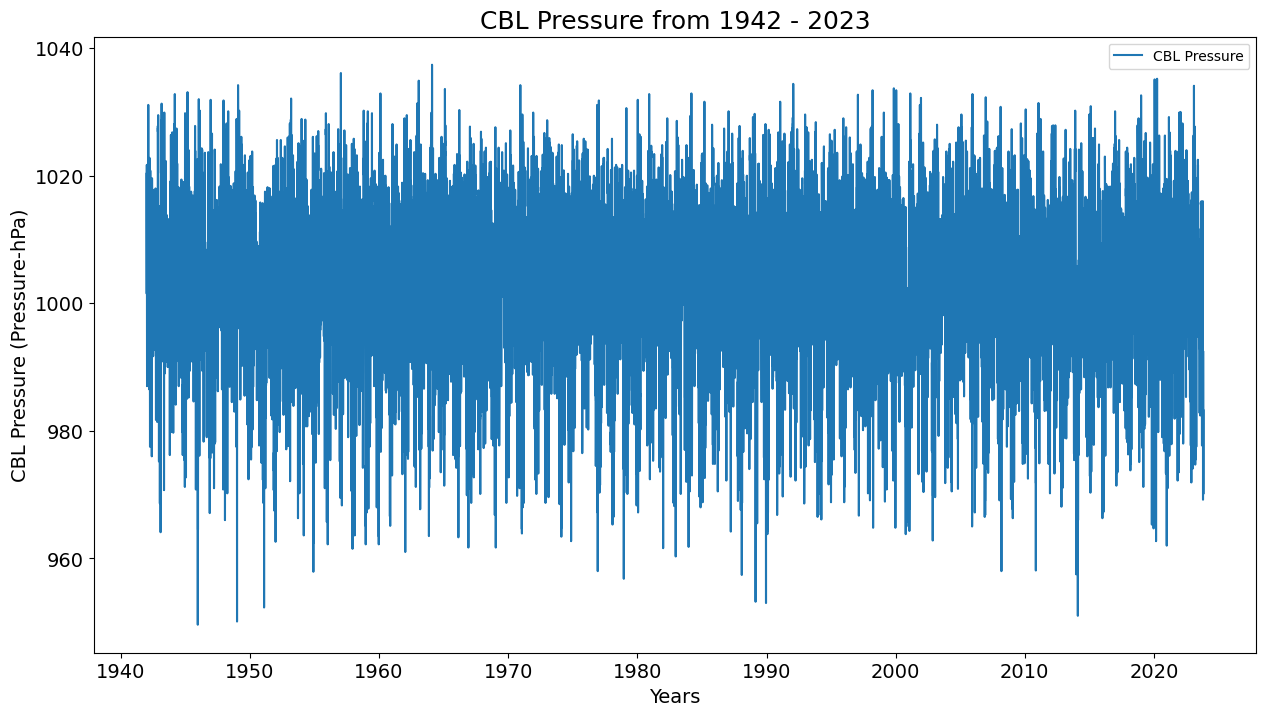

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the line using Seaborn
sns.lineplot(data=data_cbl_1, x='date', y='cbl_pressure', label='CBL Pressure', ax=ax)

# Set plot title and axis labels
ax.set_title('CBL Pressure from 1942 - 2023', fontsize=18)
ax.set_xlabel('Years', fontsize=14)
ax.set_ylabel('CBL Pressure (Pressure-hPa)', fontsize=14)

# Set tick labels font size and rotation
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)

# Show the legend
ax.legend()

# Display the plot
plt.show()


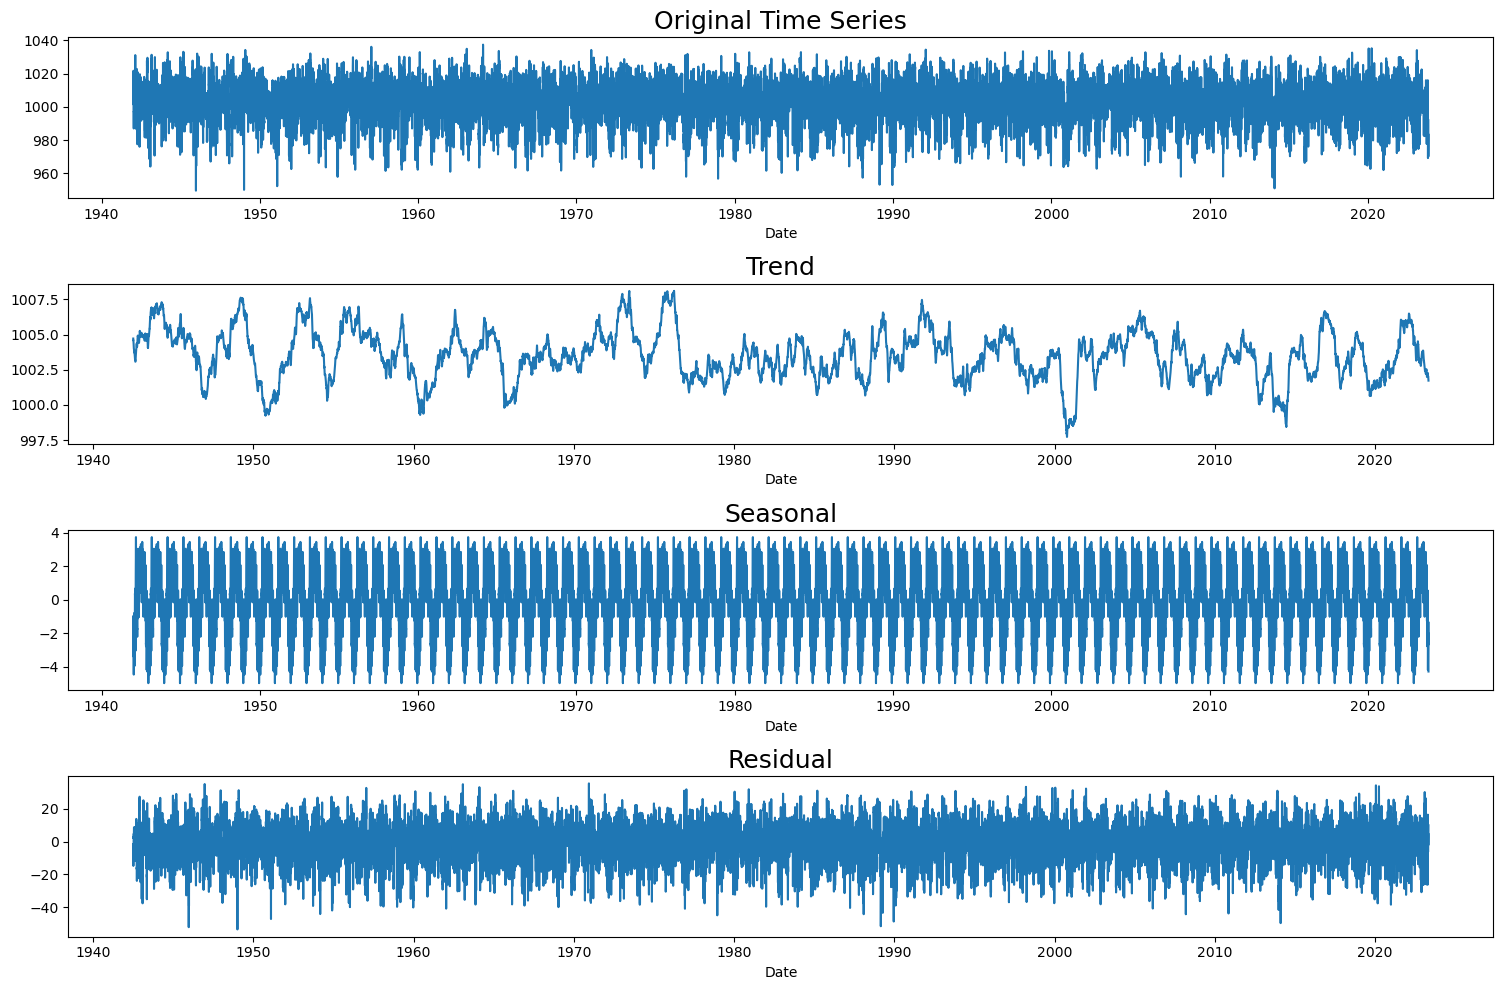

In [24]:
# Perform seasonal decomposition
result = seasonal_decompose(data_cbl_1['cbl_pressure'], model='additive', period=365)

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 10))

# Original time series
axes[0].plot(data_cbl_1.index, data_cbl_1['cbl_pressure'], label='Original')
axes[0].set_title('Original Time Series', fontsize=18)
axes[0].set_xlabel('Date')

# Trend component
axes[1].plot(result.trend.index, result.trend, label='Trend')
axes[1].set_title('Trend', fontsize=18)
axes[1].set_xlabel('Date')

# Seasonal component
axes[2].plot(result.seasonal.index, result.seasonal, label='Seasonal')
axes[2].set_title('Seasonal', fontsize=18)
axes[2].set_xlabel('Date')

# Residual component
axes[3].plot(result.resid.index, result.resid, label='Residual')
axes[3].set_title('Residual', fontsize=18)
axes[3].set_xlabel('Date')

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

<a id = 'from_2019_onwards'></a>

## From 2019 Onwards

In [25]:
data_cbl['date'] = pd.to_datetime(data_cbl.date)

In [26]:
#set date as index
data_cbl.set_index('date', inplace=True)

In [27]:
#considering data from 2019 onwards
start_date = pd.to_datetime('2019-01-01')
data_cbl_2019 = data_cbl[start_date:]

In [28]:
#show result
data_cbl_2019

,cbl_pressure
date,
2019-01-01,1027.8
2019-01-02,1032.6
2019-01-03,1031.1
2019-01-04,1030.9
2019-01-05,1027.7
...,...
2023-10-27,974.2
2023-10-28,970.1
2023-10-29,972.0


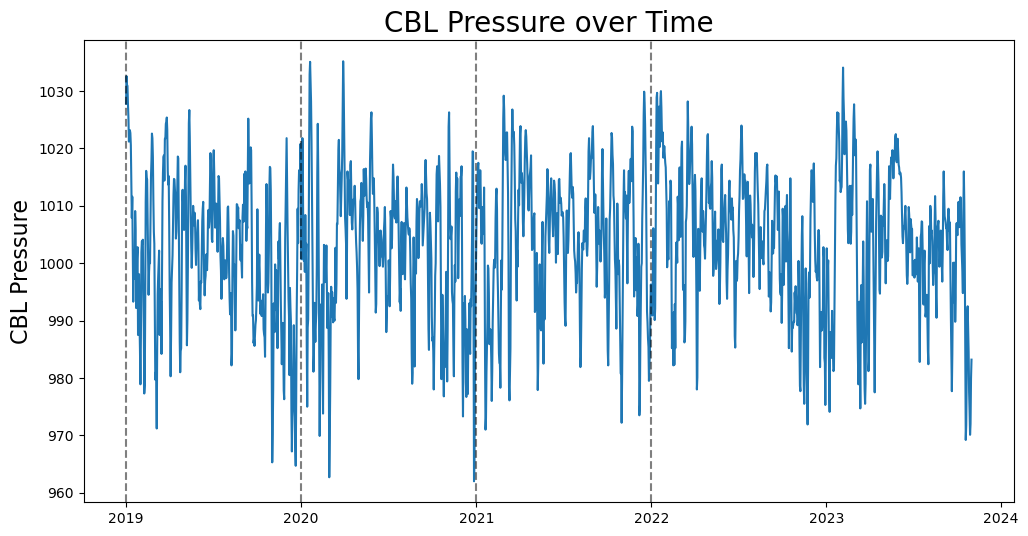

In [78]:
#CBL pressure over time
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the CBL Pressure over time
ax.plot(data_cbl_2019.index, data_cbl_2019['cbl_pressure'])

# Set plot title and axis labels
ax.set_title('CBL Pressure over Time', fontsize=20)
ax.set_ylabel('CBL Pressure', fontsize=16)

# Add vertical lines for each year from 2019 to 2022
for year in range(2019, 2023):
    ax.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.5)

# Display the plot
plt.show()

### Plot the boxplot of the cbl_pressure with respect to the different years.

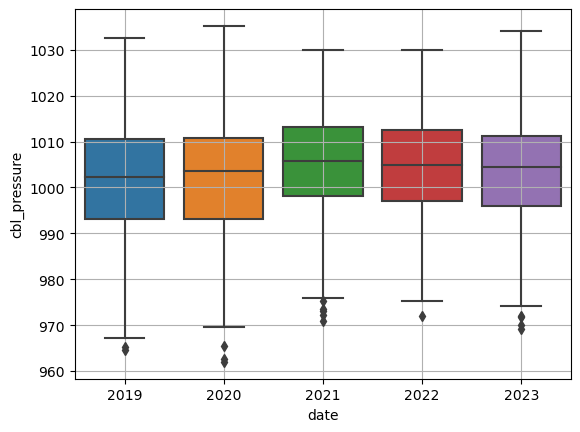

In [30]:
sns.boxplot(x = data_cbl_2019.index.year,y = data_cbl_2019['cbl_pressure'])
plt.grid();

# Seasonality Check

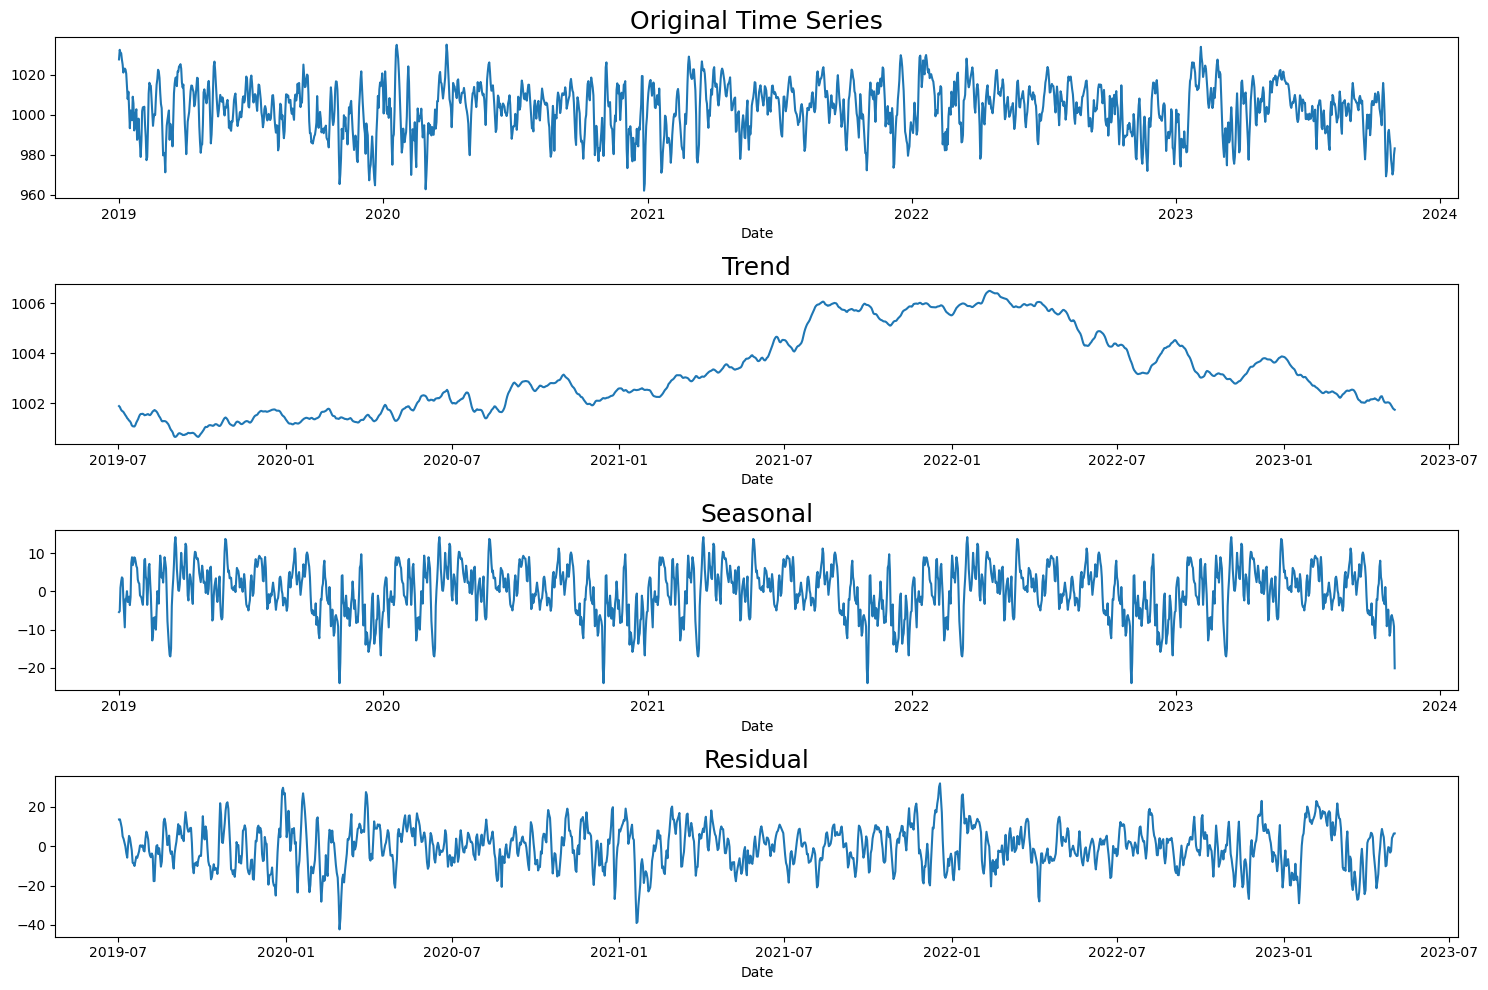

In [31]:
result = seasonal_decompose(data_cbl_2019['cbl_pressure'], model='additive', period=365)

# original time series
plt.figure(figsize=(15, 10))
plt.subplot(4, 1, 1)
plt.plot(data_cbl_2019.index, data_cbl_2019['cbl_pressure'], label='Original')
plt.title('Original Time Series', fontsize=18)
plt.xlabel('Date')

# trend component
plt.subplot(4, 1, 2)
plt.plot(result.trend.index, result.trend, label='Trend')
plt.title('Trend', fontsize=18)
plt.xlabel('Date')

# seasonal component
plt.subplot(4, 1, 3)
plt.plot(result.seasonal.index, result.seasonal, label='Seasonal')
plt.title('Seasonal', fontsize=18)
plt.xlabel('Date')

# residual component
plt.subplot(4, 1, 4)
plt.plot(result.resid.index, result.resid, label='Residual')
plt.title('Residual', fontsize=18)
plt.xlabel('Date')

plt.tight_layout()
plt.show()


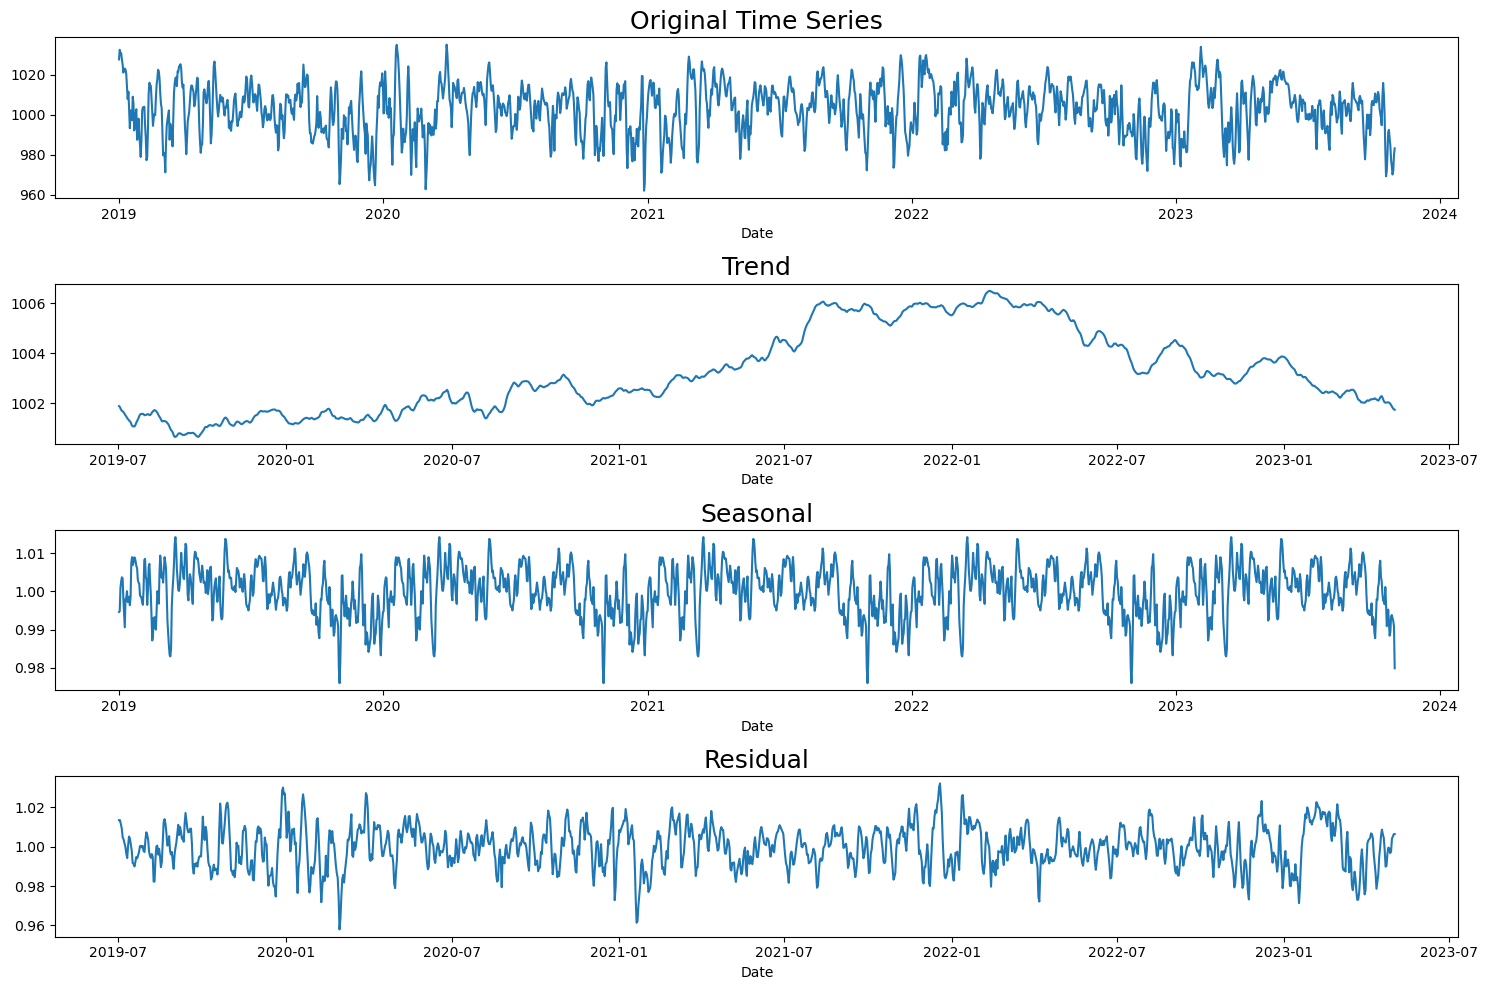

In [32]:
result = seasonal_decompose(data_cbl_2019['cbl_pressure'], model='multiplicative', period=365)

# original time series
plt.figure(figsize=(15, 10))
plt.subplot(4, 1, 1)
plt.plot(data_cbl_2019.index, data_cbl_2019['cbl_pressure'], label='Original')
plt.title('Original Time Series', fontsize=18)
plt.xlabel('Date')

# trend component
plt.subplot(4, 1, 2)
plt.plot(result.trend.index, result.trend, label='Trend')
plt.title('Trend', fontsize=18)
plt.xlabel('Date')

# seasonal component
plt.subplot(4, 1, 3)
plt.plot(result.seasonal.index, result.seasonal, label='Seasonal')
plt.title('Seasonal', fontsize=18)
plt.xlabel('Date')

# residual component
plt.subplot(4, 1, 4)
plt.plot(result.resid.index, result.resid, label='Residual')
plt.title('Residual', fontsize=18)
plt.xlabel('Date')

plt.tight_layout()
plt.show()


#### Observation:

- We can see the upward trend in Trend Component from 2021 onwards for the CBL Pressure but when we look at overall time series from 1942, it does not show the upward trend.
- We can see the seasonality in the Seasonal Component with cycle of 12 months.

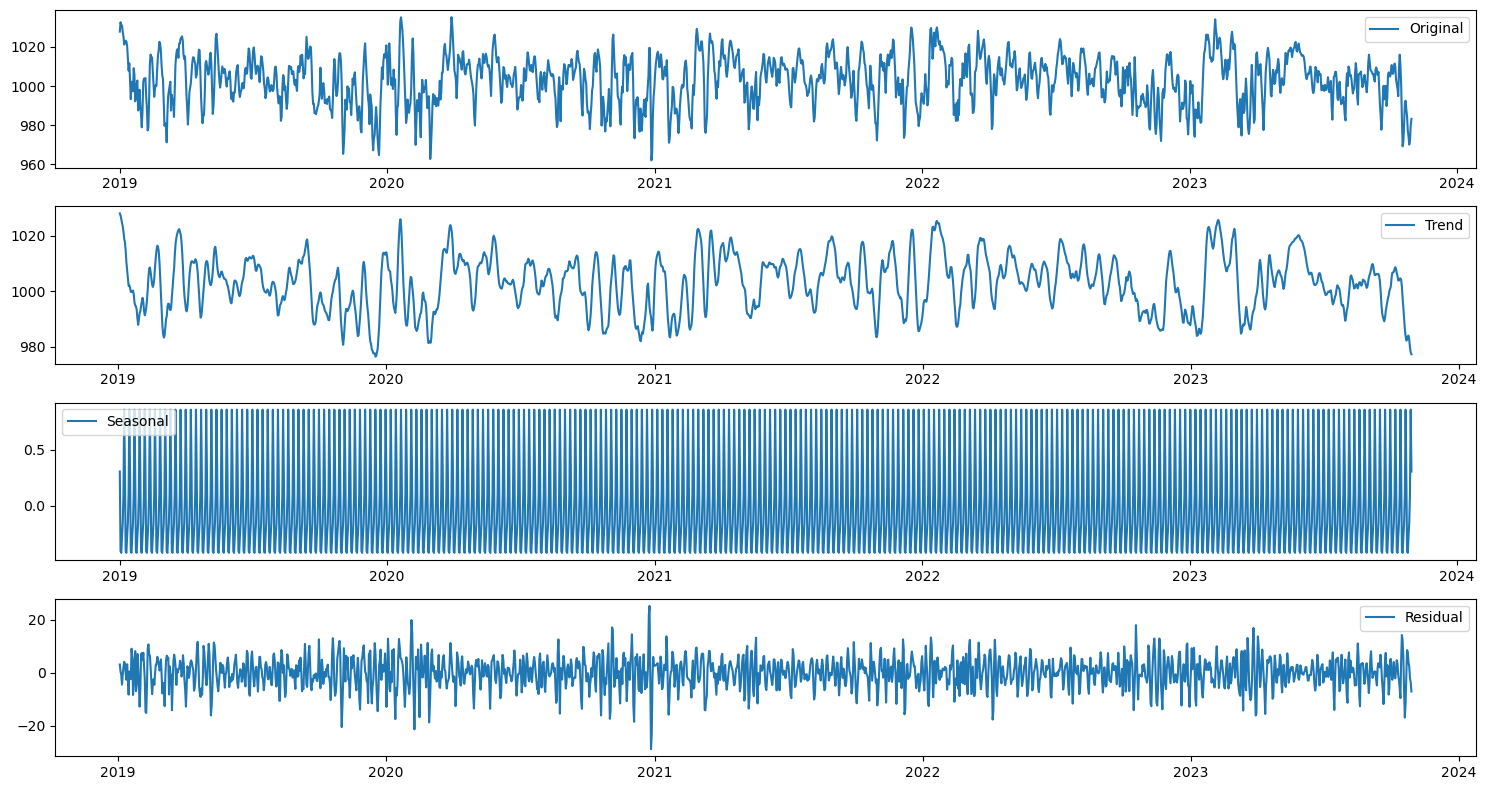

In [33]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition_mlt = seasonal_decompose(data_cbl_2019.cbl_pressure, model='additive')

# Get the components (trend, seasonal, residual)
trend = decomposition_mlt.trend
seasonal = decomposition_mlt.seasonal
residual = decomposition_mlt.resid

# Plot the components separately
plt.figure(figsize=(15, 8))  # Adjust the figure size as needed

plt.subplot(411)
plt.plot(data_cbl_2019.cbl_pressure, label='Original')
plt.legend()

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend()

plt.tight_layout()  # Adjust subplot layout for better appearance
plt.show()


### Modeling

In [34]:
# train = 2019-2022
train_start_date = pd.to_datetime('2019-01-01')
train_end_date = pd.to_datetime('2022-12-31')
df_train = data_cbl_2019[(data_cbl_2019.index >= train_start_date) & (data_cbl_2019.index <= train_end_date)]

# test = 2023
test_start_date = pd.to_datetime('2023-01-01')
df_test = data_cbl_2019[data_cbl_2019.index >= test_start_date]


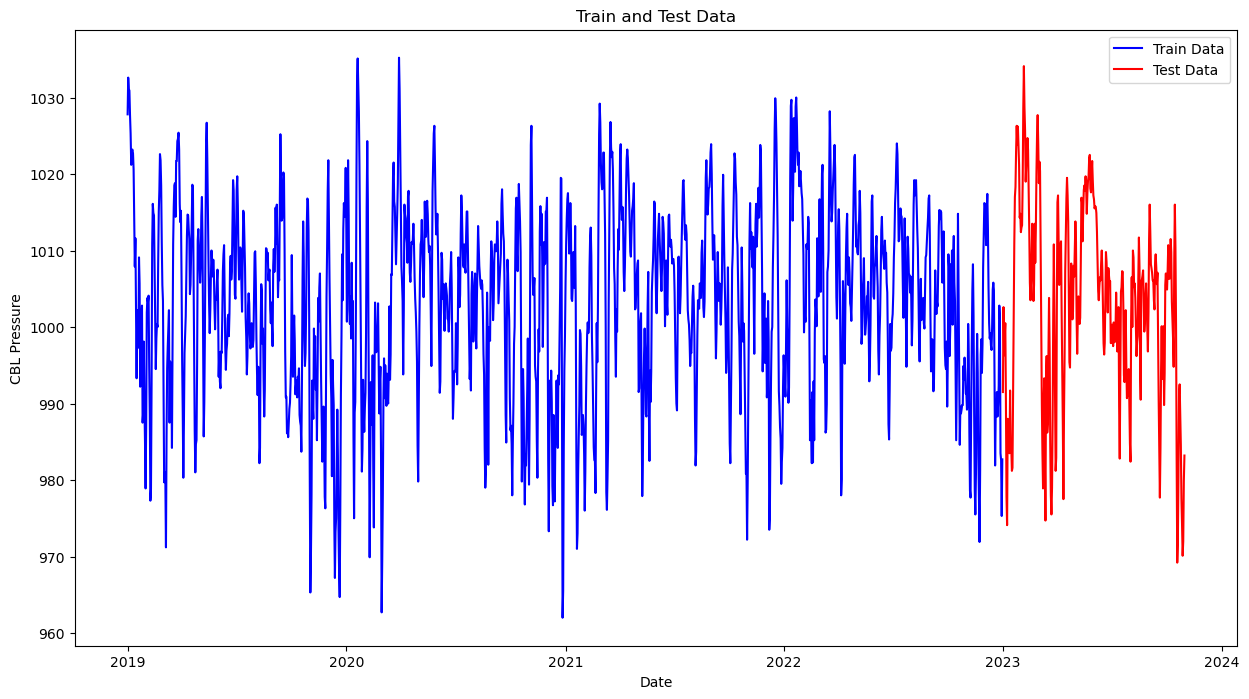

In [35]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 8))  
plt.plot(df_train.index, df_train['cbl_pressure'], label='Train Data', color='blue')
plt.plot(df_test.index, df_test['cbl_pressure'], label='Test Data', color='red')
plt.title('Train and Test Data')
plt.xlabel('Date')
plt.ylabel('CBL Pressure')
plt.legend()
plt.show()


In [36]:
#checking number of values in train and test 
print(df_train.shape)
print(df_test.shape)

(1461, 1)
(304, 1)


In [37]:
df_train.tail()

,cbl_pressure
date,
2022-12-27,1001.0
2022-12-28,983.5
2022-12-29,982.6
2022-12-30,975.3
2022-12-31,982.7


In [38]:
df_test.head()

,cbl_pressure
date,
2023-01-01,991.5
2023-01-02,1002.6
2023-01-03,996.3
2023-01-04,998.7
2023-01-05,1000.5


 Check for stationarity of the series at $\alpha$ = 0.05 using appropriate statistical tests like dickey-fuller test 

#### Defining the Hypothesis for our data:


- Null Hypothesis (H0): Time series is not stationary
- Alternate Hypothesis (H1): Time series is stationary

In [39]:
from statsmodels.tsa.stattools import adfuller

In [40]:

time_series = data_cbl_2019['cbl_pressure']

# Perform Dickey-Fuller test
result = adfuller(time_series)

# Extract and print test statistic and p-value
test_statistic = result[0]
p_value = result[1]

print(f'Test Statistic: {test_statistic:.4f}')
print(f'P-value: {p_value:.4f}')

# Interpret the results
if p_value <= 0.05:
    print('The time series is stationary (reject the null hypothesis)')
else:
    print('The time series is non-stationary (fail to reject the null hypothesis)')

Test Statistic: -10.9714
P-value: 0.0000
The time series is stationary (reject the null hypothesis)


## Model 1: Naive forecasting model 

In [44]:
Naive_train = df_train.copy()
Naive_test = df_test.copy()

In [45]:
Naive_test['naive'] = np.asarray(df_train['cbl_pressure'])[len(np.asarray(df_train['cbl_pressure']))-1]
Naive_test['naive'].head()

date
2023-01-01    982.7
2023-01-02    982.7
2023-01-03    982.7
2023-01-04    982.7
2023-01-05    982.7
Name: naive, dtype: float64

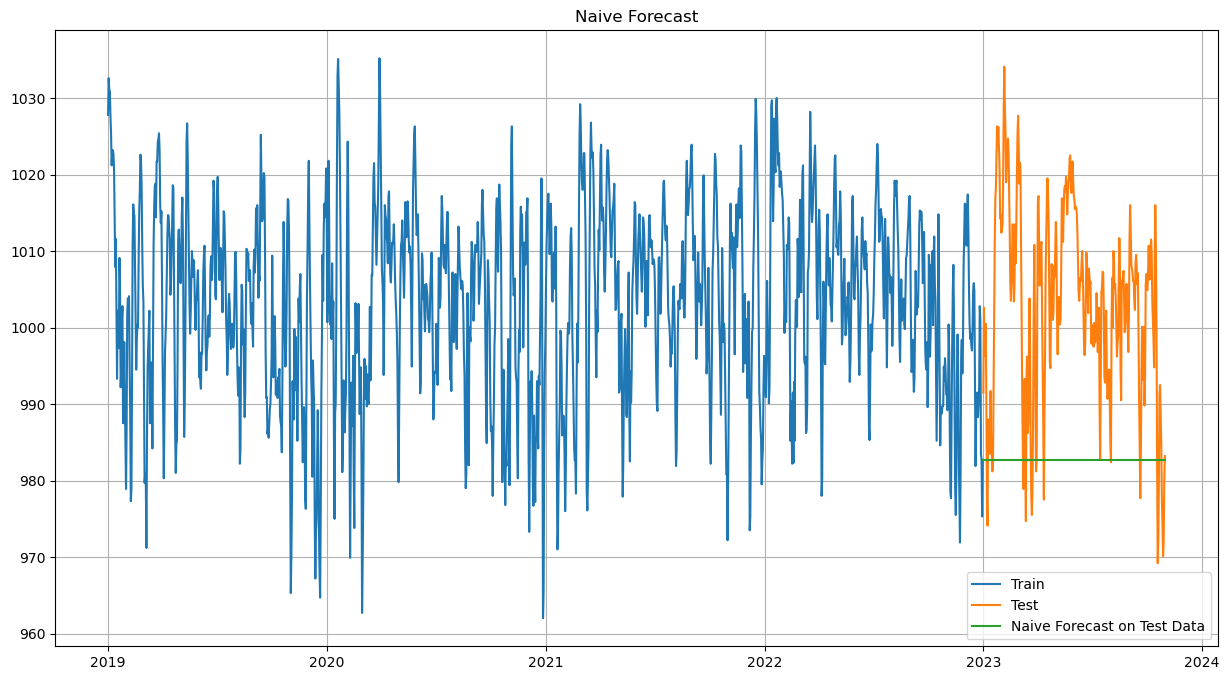

In [46]:
plt.plot(Naive_train['cbl_pressure'], label='Train')
plt.plot(df_test['cbl_pressure'], label='Test')

plt.plot(Naive_test['naive'], label='Naive Forecast on Test Data')

plt.legend(loc='best')
plt.title("Naive Forecast")
plt.grid();

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Extracting actual values from the test set
actual_values = df_test['cbl_pressure'].values

# Extracting naive forecast values
naive_forecast = Naive_test['naive'].values

# Calculate MSE, MAE, MAPE, and RMSE
mse = mean_squared_error(actual_values, naive_forecast)
mae = mean_absolute_error(actual_values, naive_forecast)
mape = np.mean(np.abs((actual_values - naive_forecast) / actual_values)) * 100
rmse = np.sqrt(mse)

# Print the metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Squared Error (MSE): 573.3832
Mean Absolute Error (MAE): 21.1684
Mean Absolute Percentage Error (MAPE): 2.0972%
Root Mean Squared Error (RMSE): 23.9454


## Model 2 : Simple Average

In [48]:
SA_train = df_train.copy()
SA_test = df_test.copy()

In [49]:
SA_test['mean_forecast'] = df_train['cbl_pressure'].mean()
SA_test.head()

,cbl_pressure,mean_forecast
date,,
2023-01-01,991.5,1003.175702
2023-01-02,1002.6,1003.175702
2023-01-03,996.3,1003.175702
2023-01-04,998.7,1003.175702
2023-01-05,1000.5,1003.175702


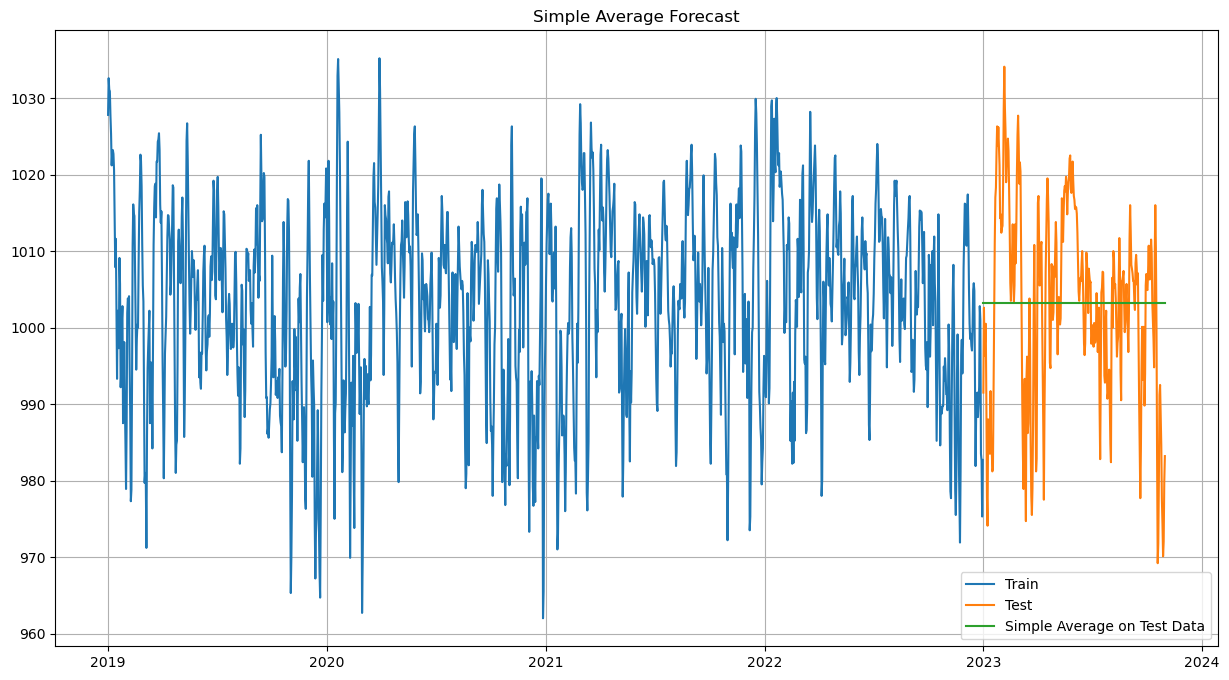

In [50]:
plt.plot(SA_train['cbl_pressure'], label='Train')
plt.plot(SA_test['cbl_pressure'], label='Test')

plt.plot(SA_test['mean_forecast'], label='Simple Average on Test Data')

plt.legend(loc='best')
plt.title("Simple Average Forecast")
plt.grid();

In [51]:
# Extracting actual values from the test set
actual_values = SA_test['cbl_pressure'].values

# Extracting simple average forecast values
mean_forecast = SA_test['mean_forecast'].values

# Calculate MSE, MAE, MAPE, and RMSE
mse = mean_squared_error(actual_values, mean_forecast)
mae = mean_absolute_error(actual_values, mean_forecast)
mape = np.mean(np.abs((actual_values - mean_forecast) / actual_values)) * 100
rmse = np.sqrt(mse)

# Print the metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Squared Error (MSE): 158.6568
Mean Absolute Error (MAE): 9.9493
Mean Absolute Percentage Error (MAPE): 0.9941%
Root Mean Squared Error (RMSE): 12.5959


## Model 3:Moving Average

In [52]:
MovingAverage = data_cbl_2019.copy()
MovingAverage.head()

,cbl_pressure
date,
2019-01-01,1027.8
2019-01-02,1032.6
2019-01-03,1031.1
2019-01-04,1030.9
2019-01-05,1027.7


#### Trailing moving averages

In [53]:
MovingAverage['Trailing_2'] = MovingAverage['cbl_pressure'].rolling(2).mean()
MovingAverage['Trailing_4'] = MovingAverage['cbl_pressure'].rolling(4).mean()
MovingAverage['Trailing_6'] = MovingAverage['cbl_pressure'].rolling(6).mean()
MovingAverage['Trailing_9'] = MovingAverage['cbl_pressure'].rolling(9).mean()

MovingAverage.head()

,cbl_pressure,Trailing_2,Trailing_4,Trailing_6,Trailing_9
date,,,,,
2019-01-01,1027.8,NaN,NaN,NaN,NaN
2019-01-02,1032.6,1030.20,NaN,NaN,NaN
2019-01-03,1031.1,1031.85,NaN,NaN,NaN
2019-01-04,1030.9,1031.00,1030.600,NaN,NaN
2019-01-05,1027.7,1029.30,1030.575,NaN,NaN


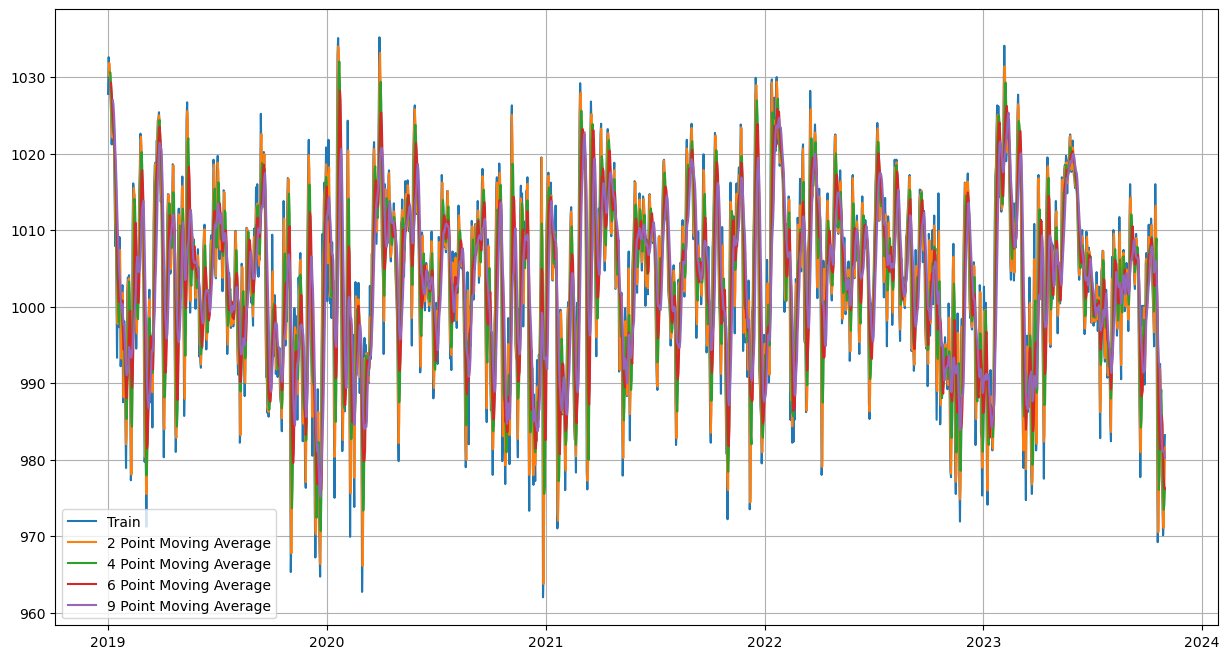

In [54]:
## Plotting on the whole data

plt.plot(MovingAverage['cbl_pressure'], label='Train')
plt.plot(MovingAverage['Trailing_2'], label='2 Point Moving Average')
plt.plot(MovingAverage['Trailing_4'], label='4 Point Moving Average')
plt.plot(MovingAverage['Trailing_6'],label = '6 Point Moving Average')
plt.plot(MovingAverage['Trailing_9'],label = '9 Point Moving Average')

plt.legend(loc = 'best')
plt.grid();

In [55]:
# Splitting trailing moving averages into train and test sets
trailing_MovingAverage_train = MovingAverage[(MovingAverage.index >= train_start_date) & (MovingAverage.index <= train_end_date)]
trailing_MovingAverage_test = MovingAverage[MovingAverage.index >= test_start_date]


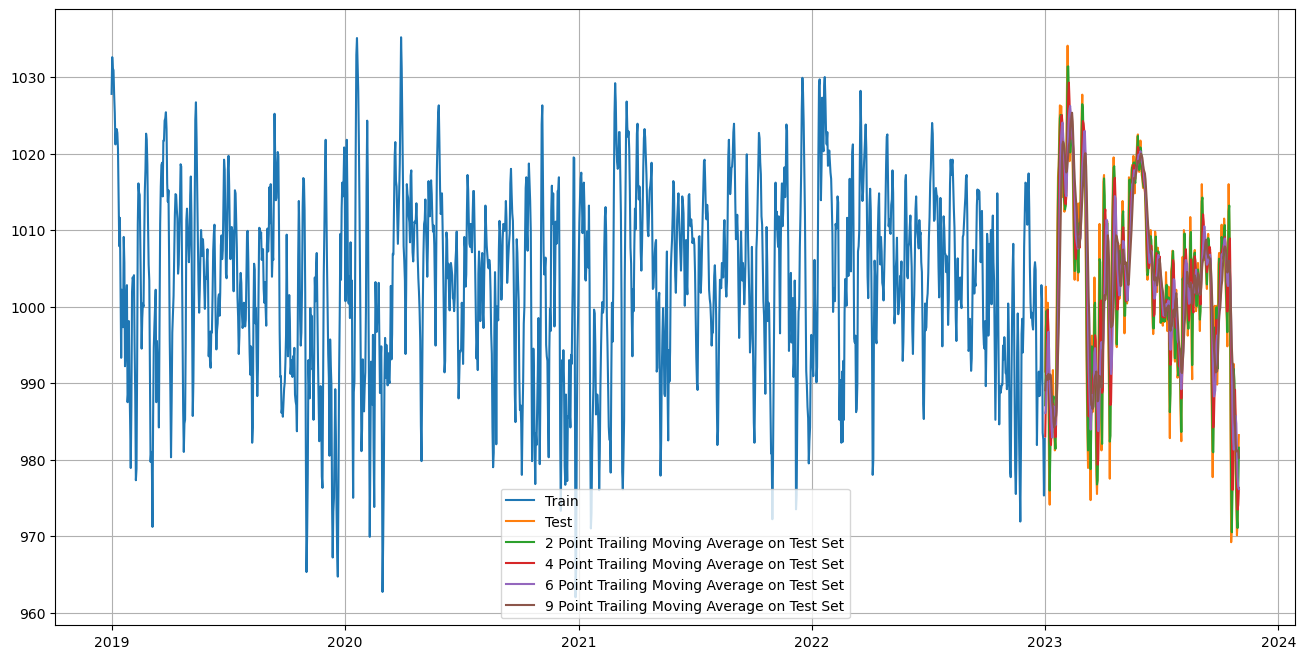

In [56]:
## Plotting on both the Training and Test data

plt.figure(figsize=(16,8))
plt.plot(trailing_MovingAverage_train['cbl_pressure'], label='Train')
plt.plot(trailing_MovingAverage_test['cbl_pressure'], label='Test')


plt.plot(trailing_MovingAverage_test['Trailing_2'], label='2 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_4'], label='4 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_6'],label = '6 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_9'],label = '9 Point Trailing Moving Average on Test Set')

plt.legend(loc = 'best')
plt.grid();

In [57]:
# Extracting actual values from the test set
actual_values = trailing_MovingAverage_test['cbl_pressure'].values

# Extracting trailing moving average forecast values
trailing_2 = trailing_MovingAverage_test['Trailing_2'].values
trailing_4 = trailing_MovingAverage_test['Trailing_4'].values
trailing_6 = trailing_MovingAverage_test['Trailing_6'].values
trailing_9 = trailing_MovingAverage_test['Trailing_9'].values

# Calculate MSE, MAE, MAPE, and RMSE for each trailing moving average
mse_2 = mean_squared_error(actual_values, trailing_2)
mae_2 = mean_absolute_error(actual_values, trailing_2)
mape_2 = np.mean(np.abs((actual_values - trailing_2) / actual_values)) * 100
rmse_2 = np.sqrt(mse_2)

mse_4 = mean_squared_error(actual_values, trailing_4)
mae_4 = mean_absolute_error(actual_values, trailing_4)
mape_4 = np.mean(np.abs((actual_values - trailing_4) / actual_values)) * 100
rmse_4 = np.sqrt(mse_4)

mse_6 = mean_squared_error(actual_values, trailing_6)
mae_6 = mean_absolute_error(actual_values, trailing_6)
mape_6 = np.mean(np.abs((actual_values - trailing_6) / actual_values)) * 100
rmse_6 = np.sqrt(mse_6)

mse_9 = mean_squared_error(actual_values, trailing_9)
mae_9 = mean_absolute_error(actual_values, trailing_9)
mape_9 = np.mean(np.abs((actual_values - trailing_9) / actual_values)) * 100
rmse_9 = np.sqrt(mse_9)

# Print the metrics for each trailing moving average
print("Metrics for 2 Point Trailing Moving Average:")
print(f"MSE: {mse_2:.4f}, MAE: {mae_2:.4f}, MAPE: {mape_2:.4f}%, RMSE: {rmse_2:.4f}")

print("\nMetrics for 4 Point Trailing Moving Average:")
print(f"MSE: {mse_4:.4f}, MAE: {mae_4:.4f}, MAPE: {mape_4:.4f}%, RMSE: {rmse_4:.4f}")

print("\nMetrics for 6 Point Trailing Moving Average:")
print(f"MSE: {mse_6:.4f}, MAE: {mae_6:.4f}, MAPE: {mape_6:.4f}%, RMSE: {rmse_6:.4f}")

print("\nMetrics for 9 Point Trailing Moving Average:")
print(f"MSE: {mse_9:.4f}, MAE: {mae_9:.4f}, MAPE: {mape_9:.4f}%, RMSE: {rmse_9:.4f}")

Metrics for 2 Point Trailing Moving Average:
MSE: 9.0260, MAE: 2.3265, MAPE: 0.2326%, RMSE: 3.0043

Metrics for 4 Point Trailing Moving Average:
MSE: 40.4592, MAE: 4.8155, MAPE: 0.4816%, RMSE: 6.3608

Metrics for 6 Point Trailing Moving Average:
MSE: 60.5742, MAE: 5.8288, MAPE: 0.5828%, RMSE: 7.7829

Metrics for 9 Point Trailing Moving Average:
MSE: 74.6328, MAE: 6.4900, MAPE: 0.6483%, RMSE: 8.6390


### Model 4: Exponential Smoothing

In [58]:
exp_SA_train = df_train.copy()
exp_SA_test = df_test.copy()

C:\Users\vinut\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


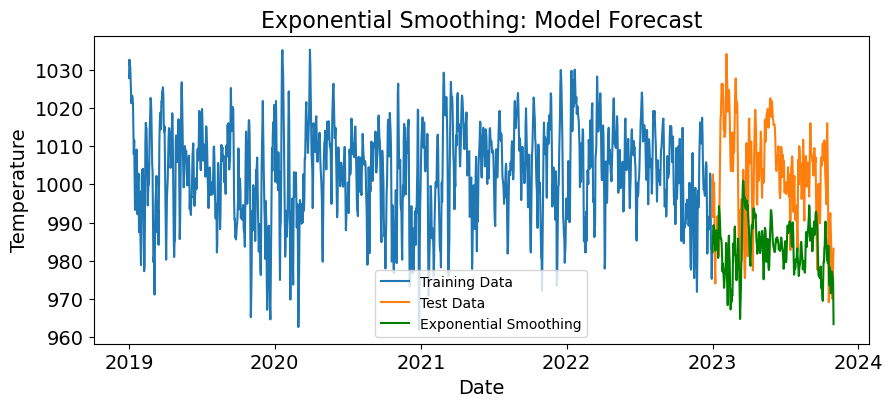

In [59]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

exp_smooth_model = ExponentialSmoothing(df_train['cbl_pressure'], seasonal='add', seasonal_periods=365)
exp_smooth_fit = exp_smooth_model.fit()
exp_smooth_forecast = exp_smooth_fit.forecast(len(df_test))



# Plotting
plt.figure(figsize=(10, 4))
plt.plot(df_train.index, df_train['cbl_pressure'], label='Training Data')
plt.plot(df_test.index, df_test['cbl_pressure'], label='Test Data')
plt.plot(df_test.index, exp_smooth_forecast, label='Exponential Smoothing', color='green')

plt.title('Exponential Smoothing: Model Forecast', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Temperature', fontsize=14)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14)
plt.legend()
plt.show()


In [60]:
# Extracting actual values from the test set
actual_values = df_test['cbl_pressure'].values

# Calculate MSE, MAE, MAPE, and RMSE
mse = mean_squared_error(actual_values, exp_smooth_forecast)
mae = mean_absolute_error(actual_values, exp_smooth_forecast)
mape = np.mean(np.abs((actual_values - exp_smooth_forecast) / actual_values)) * 100
rmse = np.sqrt(mse)

# Print the metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Squared Error (MSE): 592.8343
Mean Absolute Error (MAE): 21.1292
Mean Absolute Percentage Error (MAPE): 2.0940%
Root Mean Squared Error (RMSE): 24.3482


###  Autocorrelation and Partial Autocorrelation


    
    p,d,q
    p AR model lags
    d differencing
    q MA lags

In [61]:
import itertools
p = q = range(0, 3)
d= range(0,1)
pdq = list(itertools.product(p, d, q))

model_pdq = [(x[0], x[1], x[2], 5) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Model...')
print('Model: {}{}'.format(pdq[1], model_pdq[1]))
print('Model: {}{}'.format(pdq[1], model_pdq[2]))
print('Model: {}{}'.format(pdq[2], model_pdq[3]))
print('Model: {}{}'.format(pdq[2], model_pdq[4])) 

Examples of parameter combinations for Model...
Model: (0, 0, 1)(0, 0, 1, 5)
Model: (0, 0, 1)(0, 0, 2, 5)
Model: (0, 0, 2)(1, 0, 0, 5)
Model: (0, 0, 2)(1, 0, 1, 5)


## Model 5 :SARIMA 

In [62]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

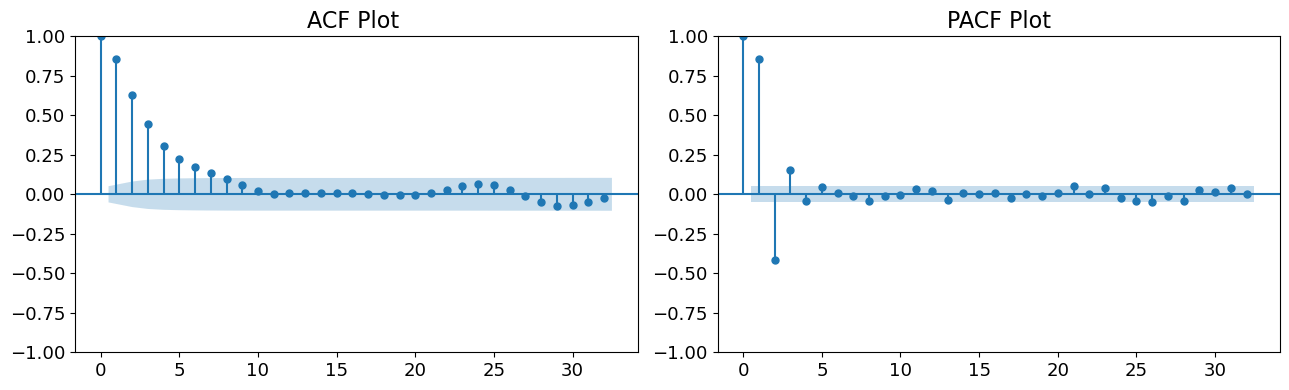

In [63]:
plt.figure(figsize=(13, 4))

# ACF
plt.subplot(1, 2, 1)
plot_acf(df_train['cbl_pressure'], ax=plt.gca(), alpha=0.05)
plt.title('ACF Plot ', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# PACF
plt.subplot(1, 2, 2)
plot_pacf(df_train['cbl_pressure'], ax=plt.gca(), alpha=0.05)
plt.title('PACF Plot', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.tight_layout()
plt.show()

### KPSS Test

- It is used to check if Time series is stationary around a deterministic trend.

In [64]:
# KPSS Test
def kpss_test(series):
    result = kpss(series)
    print(f'KPSS Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Lags Used: {result[2]}')
    print('Critical Values:')
    for key, value in result[3].items():
        print(f'   {key}: {value}')


In [65]:
kpss_test(df_train)

KPSS Statistic: 0.1782077368418919
p-value: 0.1
Lags Used: 20
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739


C:\Users\vinut\AppData\Local\Temp\ipykernel_10780\1330148522.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series)


#### Results:

The KPSS statistic falls below the 5% critical values, indicating that the p-value, which is 0.1, exceeds the significance level of 0.05. As a result, we do not have sufficient evidence to reject the Null Hypothesis.

For the series with 22 lags, a differencing method will be applied to address the observed pattern or trend.

### Differencing

In [66]:
differenced_df = df_train.diff().dropna()

diff_test = df_test.diff().dropna()

kpss_test(differenced_df)

KPSS Statistic: 0.04465692960295568
p-value: 0.1
Lags Used: 60
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739


C:\Users\vinut\AppData\Local\Temp\ipykernel_10780\1330148522.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series)


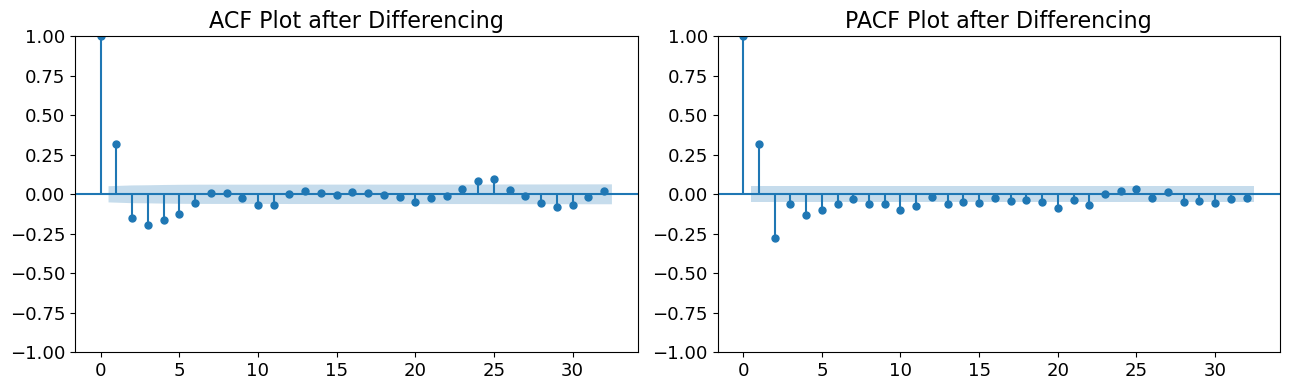

In [67]:
plt.figure(figsize=(13, 4))

# ACF
plt.subplot(1, 2, 1)
plot_acf(differenced_df['cbl_pressure'], ax=plt.gca(), alpha=0.05)
plt.title('ACF Plot after Differencing', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# PACF
plt.subplot(1, 2, 2)
plot_pacf(differenced_df['cbl_pressure'], ax=plt.gca(), alpha=0.05)
plt.title('PACF Plot after Differencing', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.tight_layout()
plt.show()

## Create a SARIMA model

In [68]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [69]:
model_SARIMA=SARIMAX(differenced_df['cbl_pressure'], order=(2,0,6), seasonal_order=(0,1,0,60))

C:\Users\vinut\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\vinut\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [70]:
model_SARIMA_fit=model_SARIMA.fit()

C:\Users\vinut\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [71]:
model_SARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        cbl_pressure   No. Observations:                 1460
Model:             SARIMAX(2, 0, 6)x(0, 1, [], 60)   Log Likelihood               -4899.723
Date:                             Wed, 03 Jan 2024   AIC                           9817.447
Time:                                     17:39:04   BIC                           9864.645
Sample:                                 01-02-2019   HQIC                          9835.091
                                      - 12-31-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0201      0.320     -0.063      0.950      -0.646       0.606
ar.L2          0.2242      0.216      1.040      0.299      -0.199       0.647
ma.L1          0.2842      0.318      0.894      0.371      -0.339       0.907
ma.L2         -0.4479      0.152     -2.943      0.003      -0.746      -0.150
ma.L3         -0.3602      0.132     -2.729      0.006      -0.619      -0.101
ma.L4         -0.2001      0.071     -2.807      0.005      -0.340      -0.060
ma.L5         -0.1608      0.055     -2.915      0.004      -0.269      -0.053
ma.L6         -0.1143      0.038     -2.987      0.003      -0.189      -0.039
sigma2        63.8568      2.743     23.282      0.000      58.481      69.233
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                46.19
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [72]:
##prediction
pred_start_date=diff_test.index[0]
pred_end_date=diff_test.index[-1]
print(pred_start_date)
print(pred_end_date)

2023-01-02 00:00:00
2023-10-31 00:00:00


## Diagnostics

In [73]:
pred_Sarima=model_SARIMA_fit.predict(start=datetime(2023,1,1),end=datetime(2023,10,31))
residuals=diff_test['cbl_pressure']-pred_Sarima

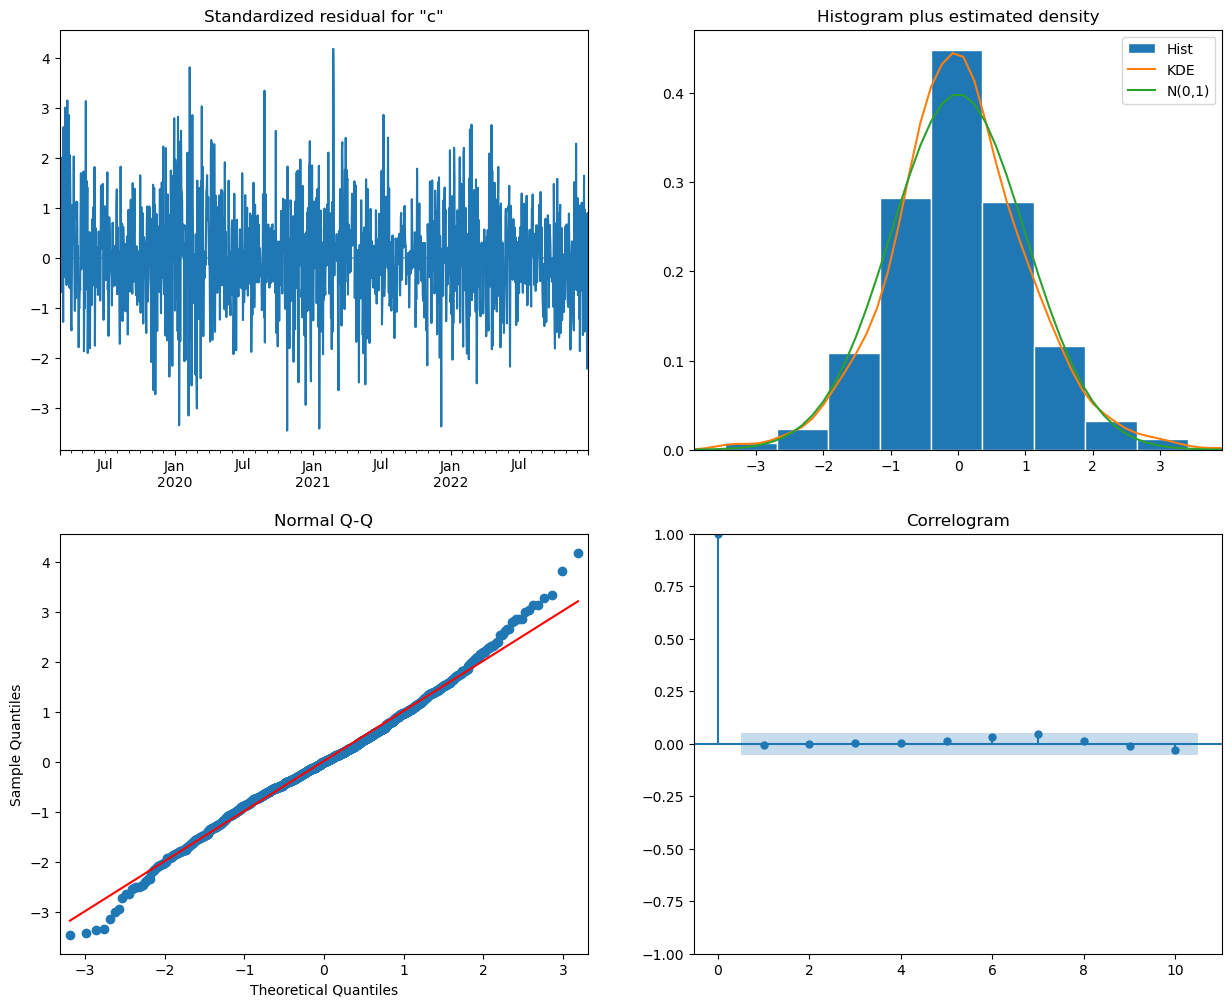

In [74]:
model_SARIMA_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

## Evaluation

In [75]:
diff_test['Predicted_SARIMA']=pred_Sarima

In [76]:
diff_test.head(2)

,cbl_pressure,Predicted_SARIMA
date,,
2023-01-02,11.1,4.065800
2023-01-03,-6.3,11.221007


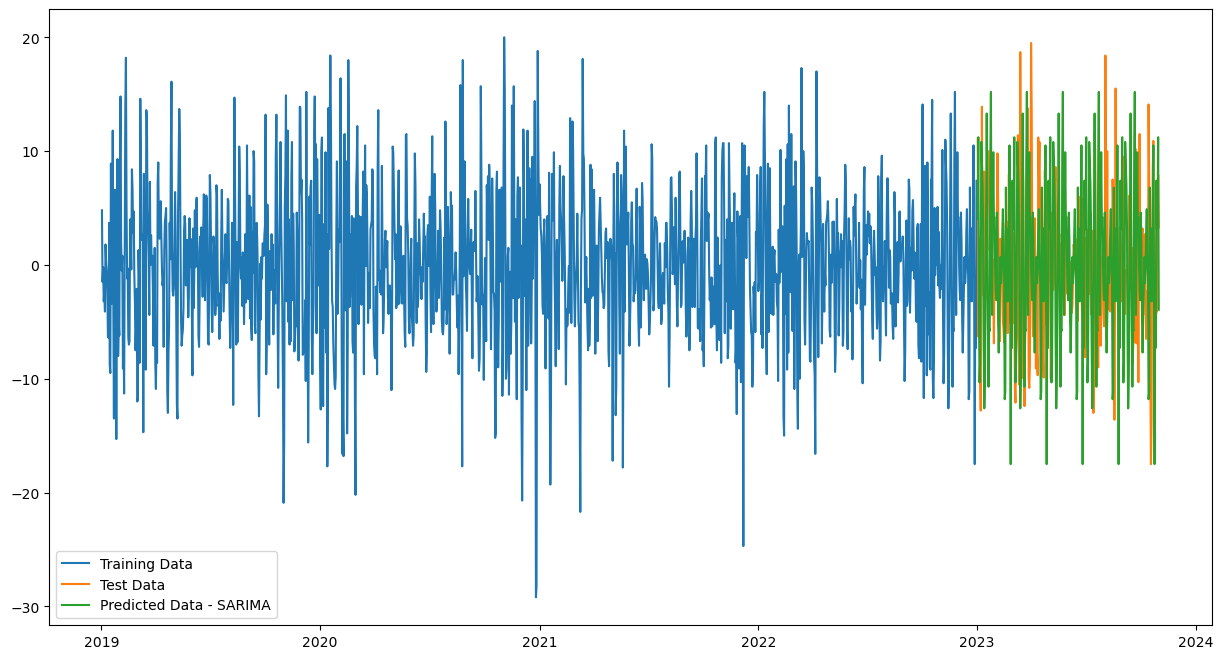

In [77]:
plt.plot(differenced_df,label='Training Data')
plt.plot(diff_test.cbl_pressure, label='Test Data')
# plt.plot(test_final.index,pred_ARIMA[0],label='Predicted Data - ARIMA')
plt.plot(diff_test.Predicted_SARIMA, label='Predicted Data - SARIMA')
plt.legend(loc='best')
# plt.grid()
plt.show()

In [79]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


predicted_values = diff_test['Predicted_SARIMA']
actual_values = diff_test['cbl_pressure']

# Calculate metrics
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = mean_squared_error(actual_values, predicted_values, squared=False)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 7.3871
Mean Squared Error (MSE): 83.8657
Root Mean Squared Error (RMSE): 9.1578
